In [1]:
# !pip install tensorflow

import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

In [2]:
# Authenticate to your cloud account
from google.colab import auth
from google.cloud import bigquery
# from google.colab import data_table

project = 'just-nova-382506'
location = 'US' 
client = bigquery.Client(project=project, location=location)

# data_table.disable_dataframe_formatter()
auth.authenticate_user()

In [3]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_116c7b5b_18748006925') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT original_tags, 
       REGEXP_REPLACE(text, 
       r"(?:tensorflow|tf|keras|matplotlib|plt|pd|sklearn|pandas|scikit-learn)", 
       "apple") as text
FROM 
       (SELECT LOWER(CONCAT(title, " ", REGEXP_REPLACE(body, r"<[^>]*>", ""))) AS text,
              REPLACE(tags, "|", ",") as original_tags
       FROM `bigquery-public-data.stackoverflow.posts_questions`
       WHERE REGEXP_CONTAINS(tags, r"(?:tensorflow|keras|matplotlib|pandas|scikit-learn)")) as results;


In [42]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_116c7b5b_18748006925')
results = job.to_dataframe()
results

,original_tags,text
0,"python,numpy,matplotlib",how to modify a numpy.recarray using its two v...
1,"python,xcode,numpy,matplotlib",apple suddenly crashes after reinstalling xcod...
2,"python,matplotlib",apple's gui doesn't allow typing in save box? ...
3,"python,performance,matplotlib,pyqt","pyqt: splash screen while loading ""heavy"" libr..."
4,matplotlib,apple: legend not displayed properly i have da...
...,...,...
439913,"python,pandas,dataframe",teach me the apple dataframe way to do this? i...
439914,"python,pandas,correlation",partial correlation in python i ran a correlat...
439915,"python,tensorflow,conv-neural-network",valueerror when calculating loss i got this va...
439916,"python,pandas,dataframe",how to keep track of different types of missin...


In [43]:
target=["tensorflow","keras","matplotlib","pandas","scikit-learn"]
results["tags"]=results["original_tags"].str.findall(r"|".join(target)).apply(",".join)

In [46]:
results.head()
results1=shuffle(results, random_state=22)
results1.head()

,original_tags,text,tags
62312,"python,tensorflow,keras",apple - concatenating two inputs of same 1st a...,"tensorflow,keras"
75401,"python,pandas",find first occurence and get column name in co...,pandas
404914,"python,csv,pandas,blank-line",how not to choose blank rows in python? i wrot...,pandas
377496,"python,keras,lstm",error on lstm input and target shapes i'm work...,keras
214578,"python,string,pandas,list,dataframe",convert list of strings to list of lists in py...,pandas


In [47]:
#data = pd.DataFrame(data=results)
data= results.drop(columns=['original_tags'])
data=data.dropna()
data = shuffle(data, random_state=22)
data

,text,tags
62312,apple - concatenating two inputs of same 1st a...,"tensorflow,keras"
75401,find first occurence and get column name in co...,pandas
404914,how not to choose blank rows in python? i wrot...,pandas
377496,error on lstm input and target shapes i'm work...,keras
214578,convert list of strings to list of lists in py...,pandas
...,...,...
120166,adding dataframe columns from existing row dat...,pandas
24932,colormesh and plot pictures with the same basi...,matplotlib
162752,logistic regression test input format help in ...,"pandas,scikit-learn"
252036,overlaying lines in apple graph? i'm trying to...,matplotlib


In [31]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
# print(tags_split, '\n')
# tags_split

In [49]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['tags'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

tensorflow,keras
['keras' 'matplotlib' 'pandas' 'scikit-learn' 'tensorflow']
[1 0 0 0 1]


In [27]:
# Split our data into train and test sets
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 351934
Test size: 87984


In [28]:
# Split our labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [29]:
# Pre-processing data: create our tokenizer class
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Overwriting preprocess.py


In [30]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE=400 # This is a hyperparameter

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [32]:
# Preview the first input from our training data
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0

# Building and training our model

In [33]:
# Save the processor state of the tokenizer
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

In [34]:
def create_model(vocab_size, num_tags):
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [35]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

# Train and evaluate the model
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(
  model.evaluate(body_test, test_tags, batch_size=128)))

# Export the model to a file
model.save('keras_saved_model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                20050     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 5)                 130       
                                                                 
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2475/2475 [==============================] - 9s 3ms/step - loss: 0.1319 - accuracy: 0.8528 - val_loss: 0.1084 - val_accuracy: 0.8806
Epoch 2/3
2475/2475 [==============================] - 7s 3ms/step - loss: 0.1065 - accuracy: 0.8755 - val_loss: 0.1057 - val_accuracy: 0.8682
Epoch 3/3
688/688 [=========

# Test our model locally

In [36]:
# Use custom model prediction to save our model + tokenizer
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)

Writing model_prediction.py


In [74]:
test_requests = [
  "Tensor('args_0:0', shape=(), dtype=string), type: <class 'tensorflow.python.framework.ops.Tensor'>, valid types: <class 'str'> I have been trying to run this code for making image datasets by tensorflow(2.12.0) with images in AWS S3 bucket. But I am getting this error when trying to execute it. ParamValidationError: Parameter validation failed: Invalid type for parameter Key, value: Tensor('args_0:0', shape=(), dtype=string), type: <class 'tensorflow.python.framework.ops.Tensor'>, valid types: <class 'str'>",
  "I am looking for a way to resample 5min data to 4hr data with the same 4hr intervals ie. 0:00 , 4:00,8:00 regardless of the start. There is an offset parameter but this doesn't allow me to set the intervals and I am unsure how i would calculate this offset on the fly for different starting times. data_4hr = df.resample('4H', origin='end').agg(  OrderedDict([ ('Open', 'first'), ('High', 'max'), ('Low', 'min'), ('Close', 'last')) )"
]

In [75]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(test_requests)
print(results)

for i in range(len(results)):
  print('Predicted labels:')
  for idx,val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

1/1 [==============================] - 0s 53ms/step
[[0.23234456777572632, 0.0019265312002971768, 0.004992923233658075, 0.007039365358650684, 0.9520633220672607], [0.0001951001468114555, 0.08150306344032288, 0.9384457468986511, 0.019567733630537987, 0.0011752615682780743]]
Predicted labels:
tensorflow


Predicted labels:
pandas




In [72]:
test_requests = [
  "How A Neural Network Function within a Baysian Optimization Function I made a neural network model that uses 4 inputs and 1 output to replace an original function that takes too long to compute. I want to use the trained neural network in place of the original function in a Baysian Optimization function. The original code I had just called the original function and gave it some inputs. I am trying to figure out how to use the neural network as a function within this function. Any help would be greatly appreciated! I'm thinking about just defining a new function that has the neural network's parameters and weights within it, but I'm not sure how to do that. I tried calling the model.predict() function, but then I get an error from the neural network library complaining that there are no inputs to the model."
  "How to extract exact matches with list from a dataframe column? I have a large dataframe with text that I want to use to find matches from a list of words (around 1k words in there). I have managed to get the absence/presence of the word from the list in the dataframe, but it is also important to me to know which word matched. Sometimes there is exact match with more than one word from the list, I would like to have them all. I tried to use the code below, but it gives me partial matches - syllables instead of full words."
]

# Package our model and deploy to AI platform

In [58]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["preprocess.py", "model_prediction.py"]
)

Writing setup.py


In [ ]:


!gsutil cp keras_saved_model.h5 gs://your_gcs_bucket/
!gsutil cp processor_state.pkl gs://your_gcs_bucket/

In [ ]:
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://your_gcs_bucket/packages/so_predict-0.1.tar.gz

In [ ]:
!gcloud config set project your-cloud-project

In [ ]:
!gcloud ml-engine models create your_model_name

# Interpreting our model with SHAP

In [59]:
!pip install shap
!pip install colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 39.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colored: filename=colored-1.4.4-py3-none-any.whl size=14268 sha256=a9584faae1b782c4f05e63d2b6961f5022dd2b6add304954a8ad29e373fd99ab
  Stored in directory: /root/.cache/pip/wheels/7a/f5/27/54cfa98930f018369067d8d02e508e053b1fec3704c258916b
Successfully built colored


In [62]:
import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

In [63]:
words = processor._tokenizer.word_index

In [64]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'apple', 'i', '1', 'to', 'a', 'in', 'quot', '2', 'and', 'is', 'of', '3', 'for', 'df', 'data', 'x', 'this', 'with', 'as', '5', 'model', 'gt', 'from', '4', 'import', 'it', 'dataframe', 'have', 'that', 'y', '00', "'", 'self', 'but', '10', 'file', 'my', 'on', 'how', 'if', 'np', '01', 'not', 'column', 'train', '6', 'lt', 'nan', 'python', 'get', '7', 'be', 'like', 'name', 'code', 'values', 'using', 'am', 'input', 'c', 'index', 'columns', 'value', 'line', 'py', 'can', '8', 'size', 'test', 'print', 'true', 'b', 'do', 'want', 'so', 'error', 'output', 'shape', '12', 'are', 'lib', 'plot', 'list', 'set', 'return', 'an', '9', 'add', 'time', 'packages', 'or', 'all', 'row', '11', 'use', 'by', 'would']


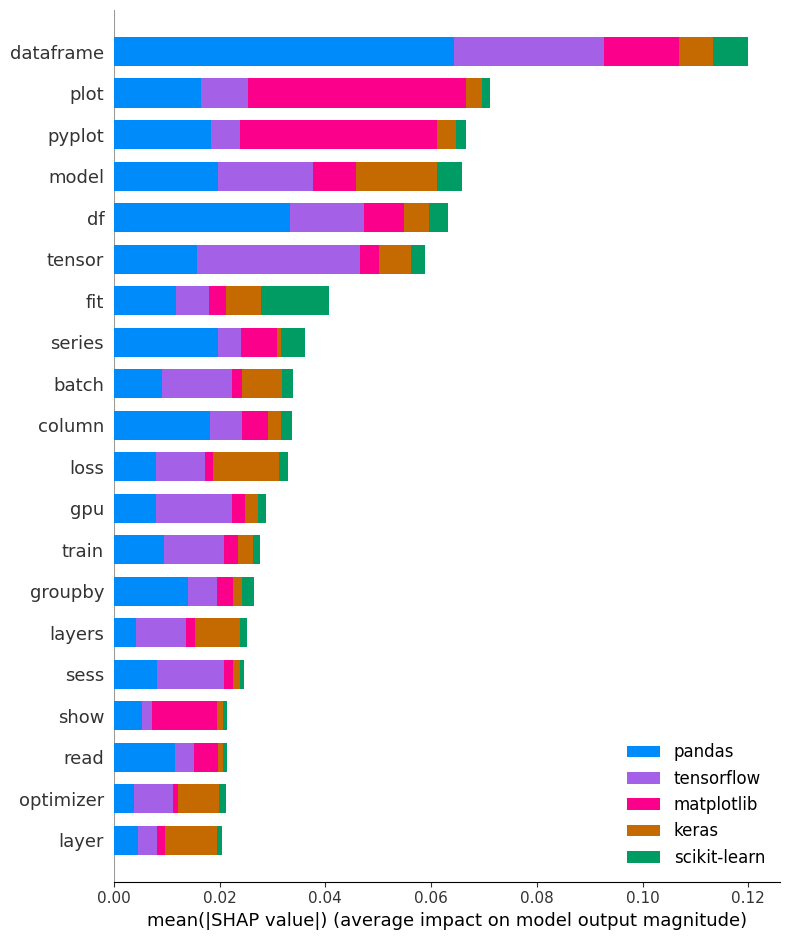

In [65]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [66]:
import colored
import re 
def colorprint(question, pos, neg):
  # Split question string on multiple chars
  q_arr = []
  q_filtered = filter(None,re.split("[, .()]+", question))
  for i in q_filtered:
    q_arr.append(i)

  color_str = []
  for idx,word in enumerate(q_arr):
    if word in pos:
      color_str.append(colored.fg("blue") + word)
    elif word in neg:
      color_str.append(colored.fg("light_red") + word)
    else:
      color_str.append(colored.fg('black') + word)

    # For wrapped printing
    if idx % 15 == 0 and idx > 0:
      color_str.append('\n')

  print(' '.join(color_str) + colored.fg('black') + " ")

In [67]:
# Print highlighted signal words for a few questions
examples_to_print = [0,7,20,22,24]

for i in range(len(examples_to_print)):
  
  # Print the actual labels
  actual = test_tags[examples_to_print[i]]
  num_labels = np.sum(actual)

  actual_labels = np.argpartition(actual, -num_labels)[-num_labels:]
  
  # Print the predicted labels
  print('Predicted labels:')
  pred_tag = model.predict([[body_test[examples_to_print[i]]]])
  for idx,tagprob in enumerate(pred_tag[0]):
    if tagprob > 0.8:
      print(tag_encoder.classes_[idx])
  print('\n')

  # Get the highest and lowest signaling words
  for idx,tag in enumerate(pred_tag[0]):
    if tag > 0.7:
      attributions = shap_vals[idx][examples_to_print[i]]
      top_signal_words = np.argpartition(attributions, -5)[-5:]
      pos_words = []
      for word_idx in top_signal_words:
        signal_wd = word_lookup[word_idx]
        pos_words.append(signal_wd)

      negative_signal_words = np.argpartition(attributions, 5)[:5]
      neg_words = []
      for word_idx in negative_signal_words:
        signal_wd = word_lookup[word_idx]
        neg_words.append(signal_wd)
      colorprint(test_qs[examples_to_print[i]],pos_words, neg_words)
  print('\n')

Predicted labels:


ValueError: ignored